In [4]:
import torch
import time
from typing import Any, Union, List, Tuple, Dict
from torch.utils.data import DataLoader, TensorDataset
# import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import os
import numpy as np
from rbm import RBM
from utils import visualize_rbm, visualize_data, project_points_to_simplex

from load_dataset import MNIST


class DBN:
    """
    Deep Belief Network
    """
    def __init__(self, input_size: int, layers: list, batch_size: int, epochs: int = 10, savefile: str = None, mode: str = "bernoulli", multinomial_top: bool=False, multinomial_sample_size: int=0, bias: bool = False, k: int = 5, gaussian_top = False, top_sigma: torch.Tensor = None, sigma: torch.Tensor = None, disc_alpha: float = 1., gaussian_middle = False):
        if (torch.cuda.is_available()):
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")
        # self.device = torch.device("cpu")
        self.input_size = input_size
        self.layers = layers
        self.bias = bias
        self.batch_size = batch_size
        self.layer_parameters = [{"W":None, "hb":None} for _ in range(len(layers))]
        self.visible_bias = None
        self.k = k
        self.mode = mode
        self.gaussian_middle = gaussian_middle
        self.gaussian_top = gaussian_top
        if (top_sigma is None):
            self.top_sigma = torch.ones((1,), dtype=torch.float64, device=self.device)/10.
        else:
            self.top_sigma = top_sigma.to(torch.float64).to(self.device)
        if (sigma is None):
            self.sigma = torch.ones((input_size,), dtype=torch.float64, device=self.device)/10.
        else:
            self.sigma = sigma.to(torch.float64).to(self.device)
        self.savefile = savefile
        self.epochs = epochs
        self.multinomial_top = multinomial_top
        self.multinomial_sample_size = multinomial_sample_size
        self.depthwise_training_loss = []
        self.top_parameters = {"W":None, "tb":None}
        self.disc_alpha = disc_alpha

    def sample_v(self, layer_index: int, y: torch.Tensor) -> torch.Tensor:
        """
        Sample visible units given hidden units
        """
        W = self.layer_parameters[layer_index]["W"]
        if (layer_index == 0):
            vb = self.visible_bias
        else:
            vb = self.layer_parameters[layer_index-1]["hb"]
        activation = torch.matmul(y, W) + vb

        if (self.mode == "bernoulli"):
            p_v_given_h = torch.sigmoid(activation)
            variable = torch.bernoulli(p_v_given_h)
        elif (self.mode == "gaussian"):
            gaussian_dist = torch.distributions.normal.Normal(activation, self.sigma)
            variable = gaussian_dist.sample()
            # Do not need p_v_given_h, otherwise it will not be correct
            p_v_given_h = torch.exp(gaussian_dist.log_prob(variable))
        else:
            raise ValueError("Invalid mode")
        return p_v_given_h, variable
    
    def sample_h(self, layer_index: int, x_bottom: torch.Tensor, label: torch.Tensor, top_down_sample: bool=False) -> torch.Tensor:
        """
        Sample hidden units given visible units
        """
        W_bottom = self.layer_parameters[layer_index]["W"]
        bias = self.layer_parameters[layer_index]["hb"]
        if (layer_index == 0):
            activation = torch.matmul(x_bottom/(self.sigma**2), W_bottom.t()) + bias
        else:    
            activation =torch.matmul(x_bottom, W_bottom.t()) + bias 

        if (layer_index == len(self.layers)-1 and self.multinomial_top):
            if (top_down_sample):
                activation = activation + torch.matmul(label/(self.top_sigma**2), self.top_parameters["W"])
            p_h_given_v = torch.softmax(activation, dim=1)
            indices = torch.multinomial(p_h_given_v, self.multinomial_sample_size, replacement=True)
            one_hot = torch.zeros(p_h_given_v.size(0), self.multinomial_sample_size, p_h_given_v.size(1), device=self.device).scatter_(2, indices.unsqueeze(-1), 1)
            variable = torch.sum(one_hot, dim=1)
        else:
            p_h_given_v = torch.sigmoid(activation)
            variable = torch.bernoulli(p_h_given_v)
        return p_h_given_v, variable
    
    def sample_r(self, x_bottom: torch.Tensor) -> torch.Tensor:
        """
        Sample reconstruction
        """
        if (self.gaussian_top):
            mean = torch.mm(x_bottom/(self.top_sigma**2), self.top_parameters["W"].t()) + self.top_parameters["tb"]
            gaussian_dist = torch.distributions.normal.Normal(mean, self.top_sigma)
            variable = gaussian_dist.sample()
            p_r_given_h = torch.exp(gaussian_dist.log_prob(variable))
        else:
            p_r_given_h = torch.ones((self.batch_size, 1), dtype=torch.float64, device=self.device)
            variable = torch.ones((self.batch_size, 1), dtype=torch.float64, device=self.device)
        return p_r_given_h, variable
        
    def generate_input_for_layer(self, index: int, dataloader: DataLoader) -> DataLoader:
        """
        Generate input for layer
        """
        input_layer = []
        input_labels = []
        if (index == 0):
            return dataloader
        else:
            for batch, label in dataloader:
                if (self.gaussian_middle):
                    x_dash, _ = self.generate_input_dataset_for_layer(index, batch, label)

                else:
                    _, x_dash = self.generate_input_dataset_for_layer(index, batch, label)
                input_layer.append(x_dash)
                input_labels.append(label)
            input_data = torch.cat(input_layer, dim=0)
            input_labels = torch.cat(input_labels, dim=0)
            if not torch.all((input_data >= 0) & (input_data <= 1)):
                raise ValueError("Tensor contains elements outside the range [0, 1].")
            dataset = TensorDataset(input_data, input_labels)
            hidden_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
            return hidden_loader

    def generate_input_dataset_for_layer(self, index: int, dataset: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
        """
        Generate input for layer
        """
        if (index == 0):
            return None, dataset
        else:
            x_gen = []
            for _ in range(self.k):
                x_dash = dataset.to(self.device)
                label = label.unsqueeze(1).to(torch.float64).to(self.device)
                for i in range(index):  
                    p_x, x_dash = self.sample_h(i, x_dash, label)
                x_gen.append(p_x)
            x_dash = torch.stack(x_gen)
            x_dash = torch.mean(x_dash, dim=0)
            x_binary = torch.bernoulli(x_dash)

            if not torch.all((x_dash >= 0) & (x_dash <= 1)):
                raise ValueError("Tensor contains elements outside the range [0, 1].")
            return x_dash.to(torch.float64).to(self.device), x_binary.to(torch.float64).to(self.device)
    
    def train(self, dataloader: DataLoader, savefig: str = None):
        """
        Train DBN
        """
        for index, _ in enumerate(self.layers):
            start_time = time.time()
            if (index == 0):
                vn = self.input_size
            else:
                vn = self.layers[index-1]
            hn = self.layers[index]
            if (self.gaussian_middle):
                if (index == 0):
                    input_mode = self.mode
                else:
                    input_mode = "gaussian"
            else:
                input_mode = self.mode
            target_status = False
            if (index == len(self.layers)-1):
                target_status = self.gaussian_top
                if (self.multinomial_top):
                    output_mode = "multinomial"
            else:
                output_mode = "bernoulli"
            rbm = RBM(n_components=hn, learning_rate=0.1, batch_size=self.batch_size, n_iter=self.epochs, verbose=0, add_bias=self.bias, target_in_model=target_status, hybrid=False, input_dist=input_mode, latent_dist=output_mode, target_dist='gaussian')

            hidden_loader = self.generate_input_for_layer(index, dataloader)

            rbm.fit_dataloader(hidden_loader, vn, 1, self.multinomial_sample_size, torch.mean(self.sigma).item(), torch.mean(self.top_sigma).item(), self.disc_alpha)
            self.layer_parameters[index]["W"] = torch.tensor(rbm.components_, dtype=torch.float64, device=self.device)
            self.layer_parameters[index]["hb"] = torch.tensor(rbm.intercept_hidden_, dtype=torch.float64, device=self.device)
            if (index == 0):
                self.visible_bias = torch.tensor(rbm.intercept_visible_, dtype=torch.float64, device=self.device)
            else:
                self.layer_parameters[index-1]["hb"] = torch.tensor(rbm.intercept_visible_, dtype=torch.float64, device=self.device)
            self.top_parameters["W"] = torch.tensor(rbm.target_components_, dtype=torch.float64, device=self.device)
            self.top_parameters["tb"] = torch.tensor(rbm.intercept_target_, dtype=torch.float64, device=self.device)

            print("Finished Training Layer", index, "to", index+1)
            # training_loss = self.calc_training_loss(dataloader, index+1)
            # print("Training Loss of DBN with {} layers:".format(index+1), training_loss)
            # self.depthwise_training_loss.append(training_loss)
            end_time = time.time()
            print("Time taken for training DBN layer", index, "to", index+1, "is", end_time-start_time, "seconds")
            visualize_rbm(rbm, hidden_loader, index, savefig)

            # encoded = self.encode(dataloader, index+1)
            # visualize_data(encoded, index+1)
            
        if (self.savefile is not None):
            model = self.initialize_nn_model()
            nn_savefile = self.savefile.replace(".pth", "_nn.pth")
            torch.save(model, nn_savefile)
            self.save_model()
        
        self.visualize_training_curve()

    def visualize_training_curve(self):
        """
        Visualize training curve
        """
        directory = "../results/plots/DBN/"
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt_title = "Training Loss for increasing depth of DBN"
        x = np.arange(1, len(self.depthwise_training_loss)+1)
        plt.plot(x, np.array(self.depthwise_training_loss))
        plt.xlabel("Depth")
        plt.ylabel("Training Loss")
        plt.title(plt_title)
        plt.savefig(directory + plt_title.replace(" ", "_") + ".png")
        plt.close()
        
    def calc_training_loss(self, dataloader: DataLoader, depth: int):
        '''
        '''
        train_loss = torch.tensor([0.], dtype=torch.float64, device=self.device)
        for batch_data, label in dataloader:
            v_original = batch_data.to(self.device)
            label = label.unsqueeze(1).to(torch.float64).to(self.device)
            v_reconstruct, _ = self.reconstructor(v_original, label, depth)
            train_loss += torch.mean(torch.abs(v_original - v_reconstruct))
        return train_loss.item()

    def reconstructor(self, x: torch.Tensor, y: torch.Tensor, depth: int = -1) -> torch.Tensor:
        """
        Reconstruct input
        """
        if (depth == -1):
            depth = len(self.layers)
        x_gen = []
        for _ in range(self.k):
            x_dash = x.clone()
            for i in range(depth):
                if (i == len(self.layers)-1 and self.gaussian_top):
                    top_down_sample = True
                    p_x, x_dash = self.sample_h(i, x_dash, y, top_down_sample)
                else:
                    p_x, x_dash = self.sample_h(i, x_dash, y)
            x_gen.append(p_x)
        x_dash = torch.stack(x_gen)
        x_dash = torch.mean(x_dash, dim=0)


        y_gen = []
        for _ in range(self.k):
            y_dash = torch.bernoulli(x_dash)
            for i in range(depth-1, -1, -1):
                p_y, y_dash = self.sample_v(i, y_dash)
            y_gen.append(p_y)
        y_dash = torch.stack(y_gen)
        y_dash = torch.mean(y_dash, dim=0)
        y_dash = torch.bernoulli(y_dash)

        return y_dash, x_dash

    def reconstruct(self, dataloader: DataLoader, depth: int = -1) -> DataLoader:
        """
        Reconstruct input
        """
        visible_data = []
        latent_vars = []
        data_labels = []
        for batch, label in dataloader:
            batch = batch.to(self.device)
            label = label.unsqueeze(1).to(torch.float64).to(self.device)
            visible, latent = self.reconstructor(batch, label, depth)
            visible_data.append(visible)
            latent_vars.append(latent)
            data_labels.append(label)
        visible_data = torch.cat(visible_data, dim=0)
        latent_vars = torch.cat(latent_vars, dim=0)
        data_labels = torch.cat(data_labels, dim=0)
        dataset = TensorDataset(visible_data, latent_vars, data_labels)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
    
    def encoder(self, dataset: torch.Tensor, label: torch.Tensor, depth: int) -> torch.Tensor:
        """
        Generate top level latent variables
        """
        dataset = dataset.to(self.device)
        _, x_bottom = self.generate_input_dataset_for_layer(depth-1, dataset, label)
        W_bottom = self.layer_parameters[depth-1]["W"].to(self.device)
        b_bottom = self.layer_parameters[depth-1]["hb"].to(self.device)
        activation = torch.matmul(x_bottom, W_bottom.t()) + b_bottom 
        if (depth == len(self.layers)):
            activation = activation + torch.matmul(label/(self.top_sigma**2), self.top_parameters["W"].to(self.device)) + self.top_parameters["tb"].to(self.device)
            if (self.multinomial_top):
                p_h_given_v = torch.softmax(activation, dim=1)      
        else:
            p_h_given_v = torch.sigmoid(activation)
        return p_h_given_v

    def encode(self, dataloader: DataLoader,  depth: int = -1) -> DataLoader:
        """
        Encode data
        """
        if (depth == -1):
            depth = len(self.layers)
        latent_vars = []
        labels = []
        for data, label in dataloader:
            data = data.to(self.device)
            label = label.unsqueeze(1).to(torch.float64).to(self.device)
            latent_vars.append(self.encoder(data, label, depth))
            labels.append(label)
        latent_vars = torch.cat(latent_vars, dim=0)
        labels = torch.cat(labels, dim=0)
        latent_dataset = TensorDataset(latent_vars, labels)

        return DataLoader(latent_dataset, batch_size=self.batch_size, shuffle=False)
    
    def load_model(self, savefile: str):
        """
        Load DBN or DBM model
        """
        model = torch.load(savefile, weights_only=False)
        layer_parameters = []
        for index in range(len(model["W"])):
            layer_parameters.append({"W":model["W"][index].to(self.device), "hb":model["hb"][index].to(self.device)})
            visible_bias = model["vb"]
        
        top_parameters = {"W":model["TW"].to(self.device), "tb":model["tb"].to(self.device)}
        self.layer_parameters = layer_parameters
        self.top_parameters = top_parameters
        self.visible_bias = visible_bias

    def load_nn_model(self, savefile: str):
        """
        Load nn model
        """
        dbn_model = torch.load(savefile, weights_only=False)
        for layer_no, layer in enumerate(dbn_model):
            # if (layer_no//2 == len(self.layer_parameters)-1):
            #     break
            if (layer_no%2 == 0):
                self.layer_parameters[layer_no//2]["W"] = layer.weight.to(self.device)
                if (self.bias):
                    if (layer_no == 0):
                        self.visible_bias = layer.bias.to(self.device)
                    else:
                        self.layer_parameters[layer_no//2-1]["hb"] = layer.bias.to(self.device)
                print("Loaded Layer", layer_no//2)
        for index, layer in enumerate(self.layer_parameters):
            if (index < len(self.layer_parameters)-1):
                self.layer_parameters[index]["hb"] = self.layer_parameters[index+1]["vb"]

    def save_model(self, savefile: str = None):
        """
        Save model
        """
        if (savefile is None):
            savefile = self.savefile
        model = {"W": [], "vb": None, "hb": [], "TW": None , "tb": None}
        for layer in self.layer_parameters:
            model["W"].append(layer["W"])
            model["hb"].append(layer["hb"])
        model["TW"] = self.top_parameters["W"]
        model["tb"] = self.top_parameters["tb"]
        model["vb"] = self.visible_bias
        torch.save(model, savefile)

    def initialize_nn_model(self):
        """
        Initialize model
        """
        print("The last layer will not be activated. The rest are activated using the Sigmoid function.")

        modules = []
        for index, layer in enumerate(self.layer_parameters):
            modules.append(torch.nn.Linear(layer["W"].shape[1], layer["W"].shape[0]))
            if (index < len(self.layer_parameters)-1):
                modules.append(torch.nn.Sigmoid())
        model = torch.nn.Sequential(*modules)
        model = model.to(self.device)

        for layer_no, layer in enumerate(model):
            if (layer_no//2 == len(self.layer_parameters)-1):
                break
            if (layer_no%2 == 0):
                model[layer_no].weight = torch.nn.Parameter(self.layer_parameters[layer_no//2]["W"])
        return model

MAE for all 0 selection: tensor(0.1323, dtype=torch.float64)
The whole dataset has 60000 data. The dimension of each data is 784. Batch size is 1000.


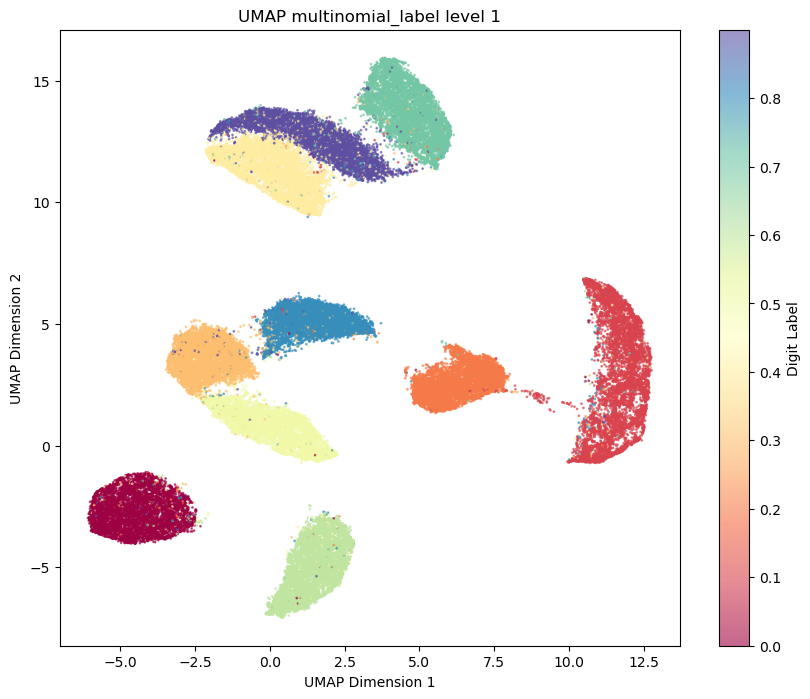

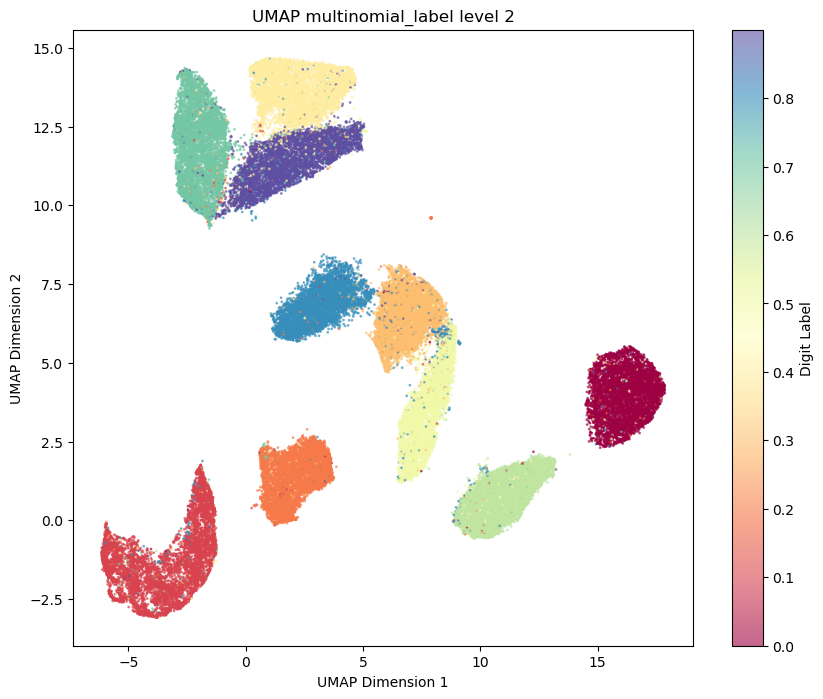

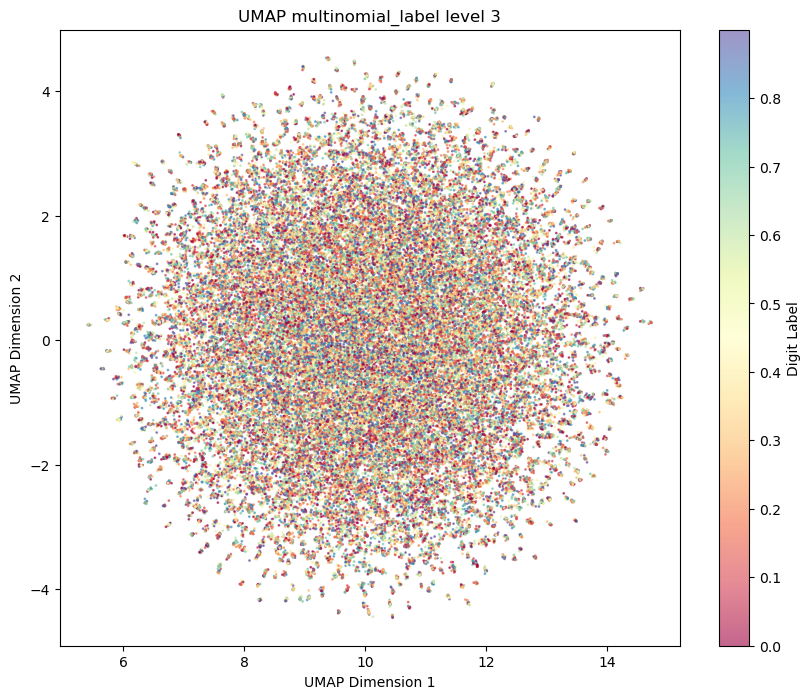

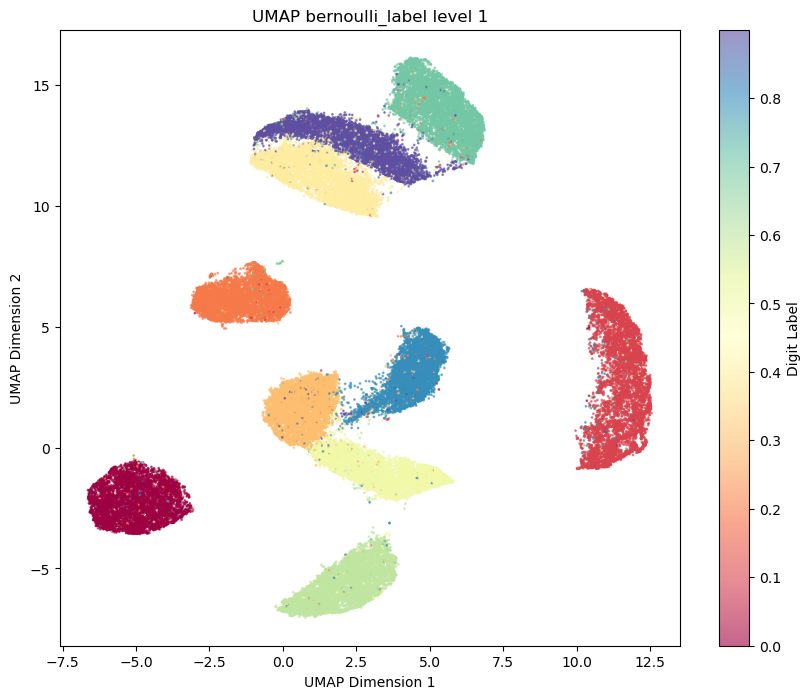

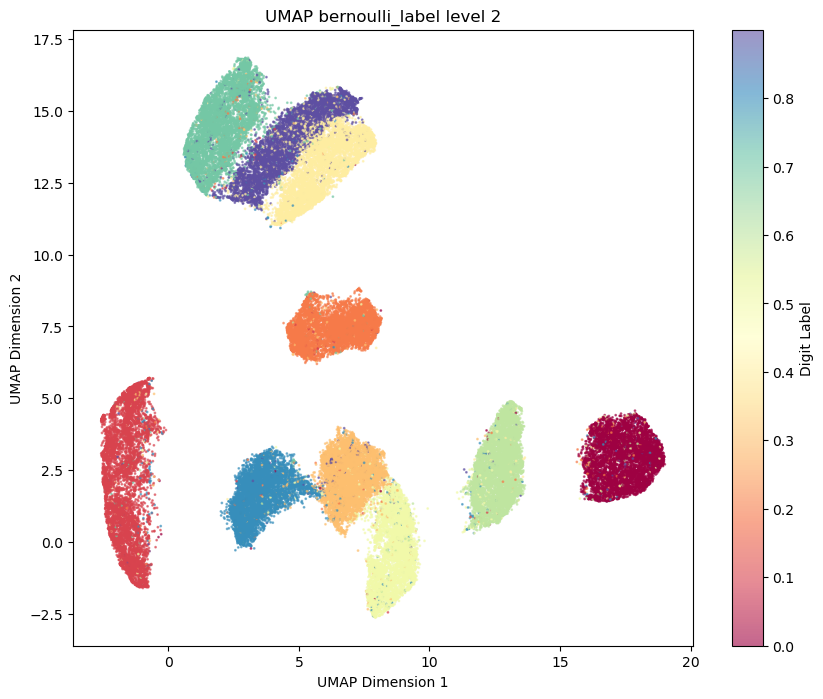

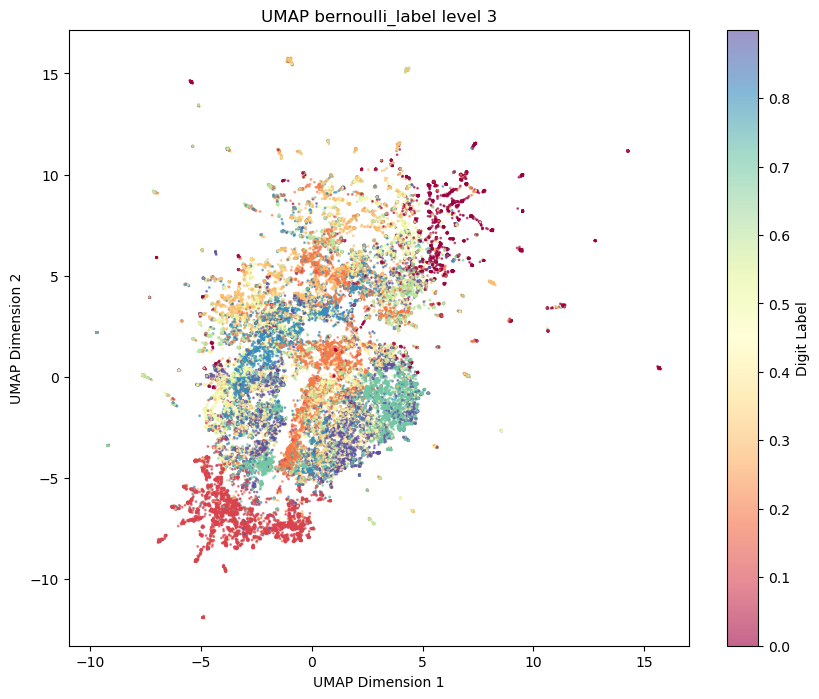

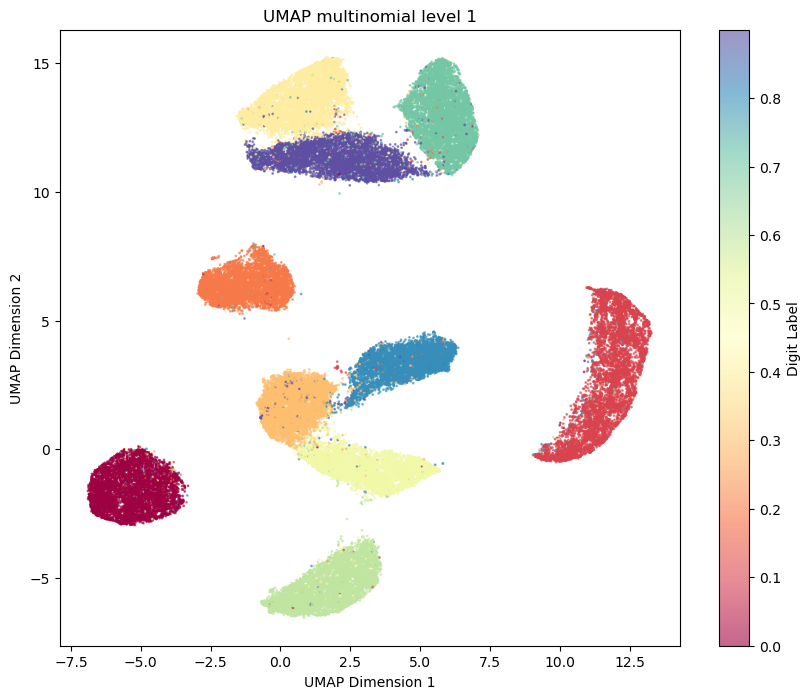

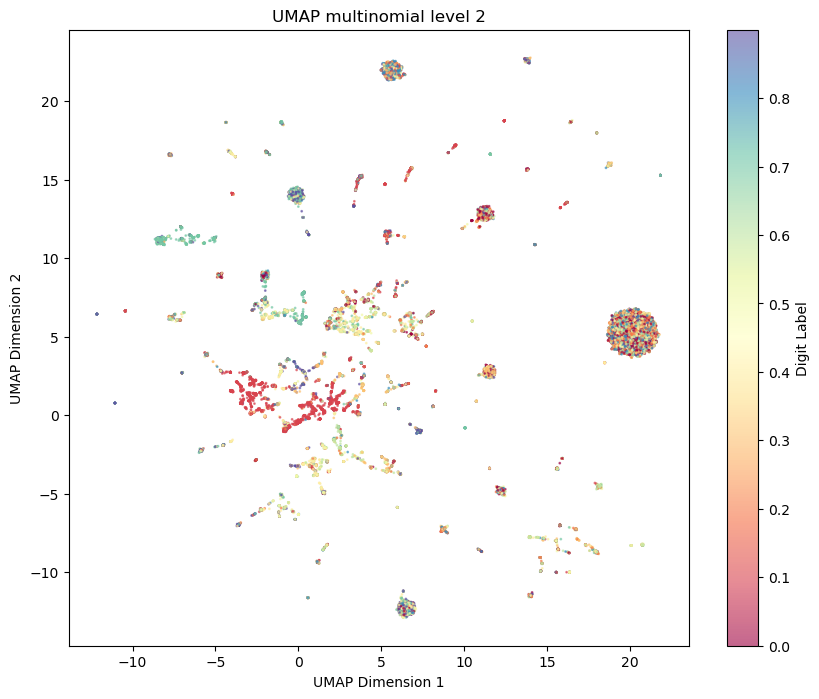

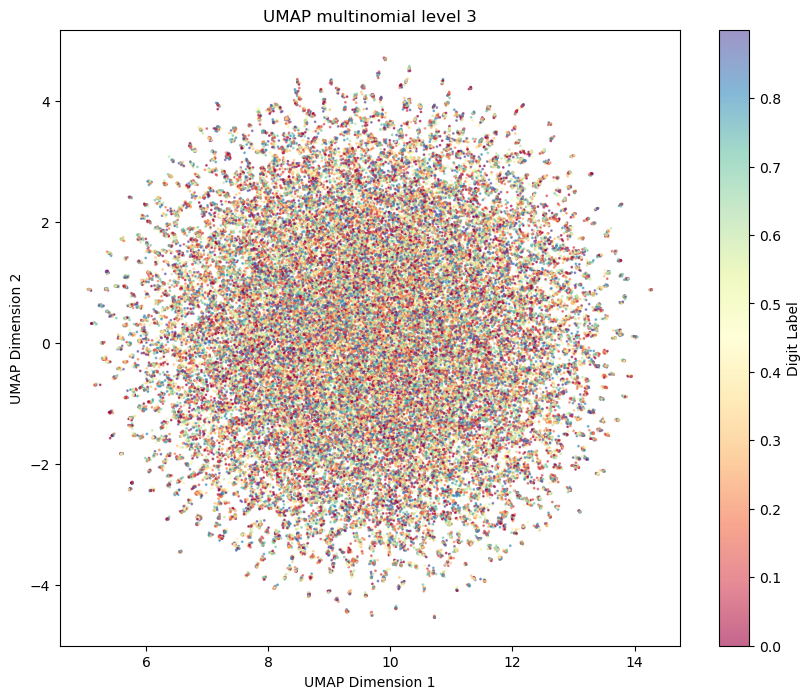

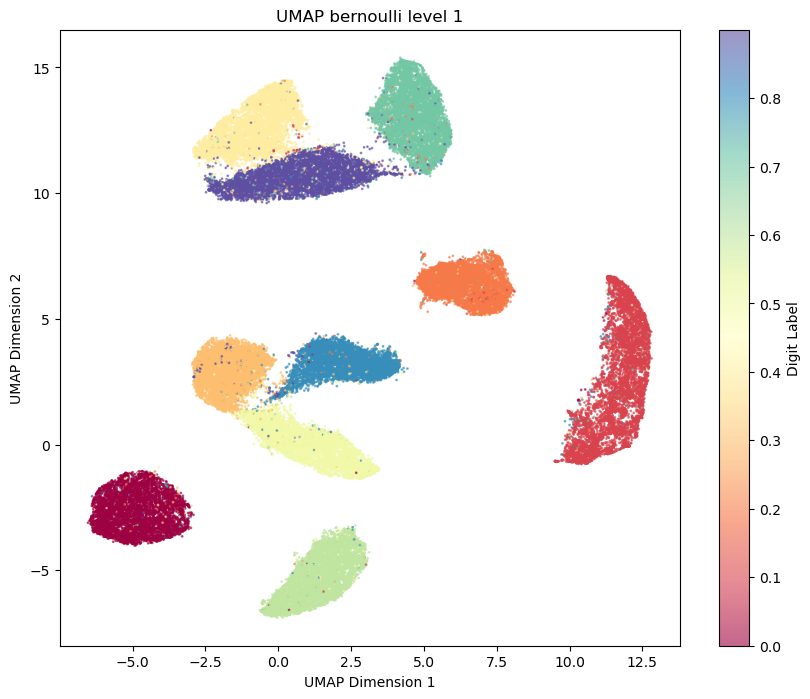

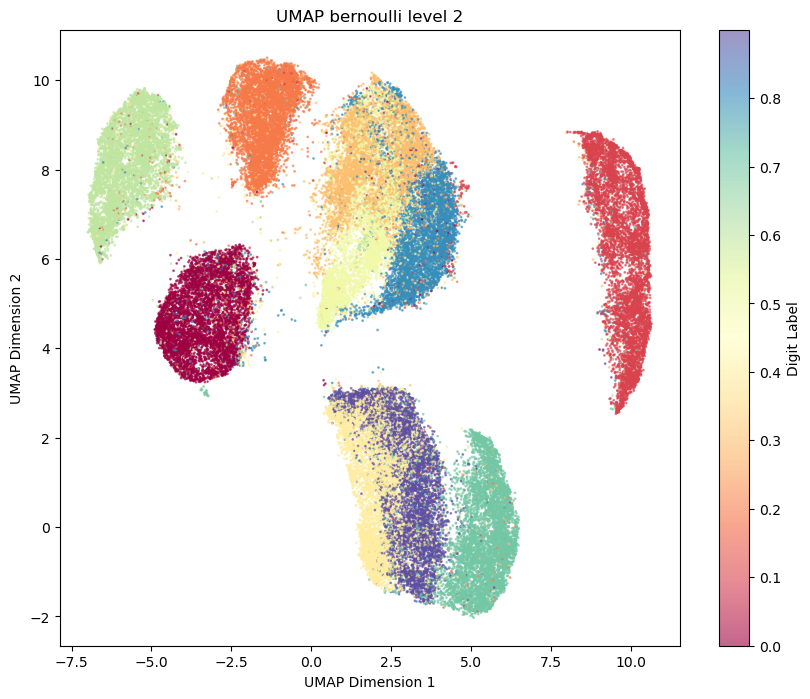

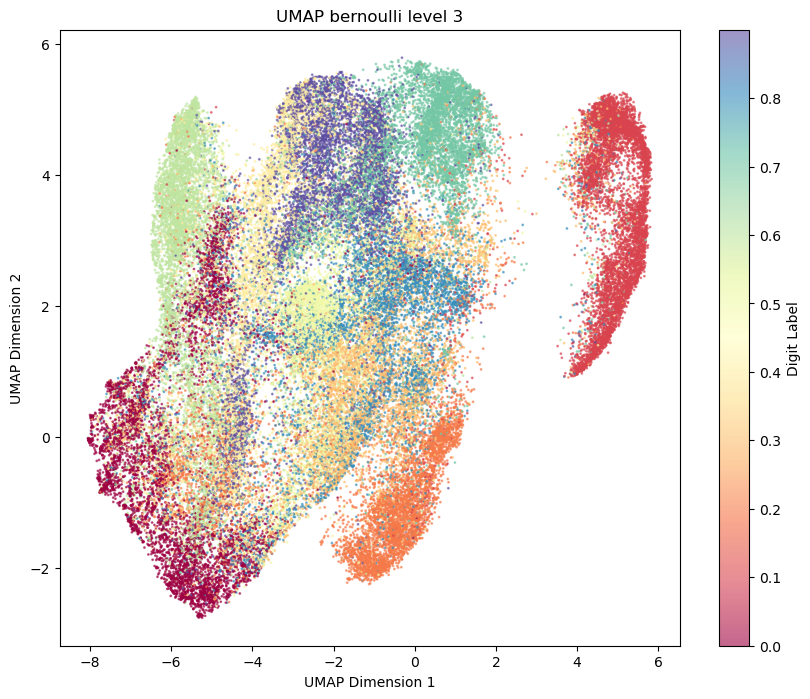

In [6]:
from umap import UMAP
import matplotlib.pyplot as plt 
import numpy as np


mnist = MNIST()
train_x, train_y, test_x, test_y = mnist.load_dataset()
train_y = train_y/10.
print('MAE for all 0 selection:', torch.mean(train_x))
batch_size = 1000	
prev_cumu_epochs = 0
epochs = 2000
datasize = train_x.shape[0]
data_dimension = train_x.shape[1]
gaussian_middle = False

print("The whole dataset has {} data. The dimension of each data is {}. Batch size is {}.".format(datasize, data_dimension, batch_size))

dataset = TensorDataset(train_x, train_y)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for experiment in ["multinomial_label", "bernoulli_label", "multinomial", "bernoulli"]:
    directory = "../results/plots/DBN/epoch_{}/".format(epochs + prev_cumu_epochs)
    experi_type = experiment
    directory = directory + "UMAP_" + experi_type + "/"
    filename = "dbn_" + experi_type + ".pth"
    if not os.path.exists(directory):
        os.makedirs(directory)

    if (experiment == "bernoulli"):
        dbn = DBN(data_dimension, layers=[500, 300, 100], batch_size=batch_size, epochs = epochs, savefile=filename, mode = "bernoulli", multinomial_top = False, multinomial_sample_size = 10, bias = False, k = 50, gaussian_top = False, top_sigma = 0.1*torch.ones((1,)), sigma = None, disc_alpha = 1., gaussian_middle = gaussian_middle)
    elif (experiment == "bernoulli_label"):
        dbn = DBN(data_dimension, layers=[500, 300, 100], batch_size=batch_size, epochs = epochs, savefile=filename, mode = "bernoulli", multinomial_top = False, multinomial_sample_size = 10, bias = False, k = 50, gaussian_top = True, top_sigma = 0.1*torch.ones((1,)), sigma = None, disc_alpha = 1., gaussian_middle = gaussian_middle)
    elif (experiment == "multinomial"):
        dbn = DBN(data_dimension, layers=[500, 300, 100], batch_size=batch_size, epochs = epochs, savefile=filename, mode = "bernoulli", multinomial_top = True, multinomial_sample_size = 10, bias = False, k = 50, gaussian_top = False, top_sigma = 0.1*torch.ones((1,)), sigma = None, disc_alpha = 1., gaussian_middle = gaussian_middle)
    elif (experiment == "multinomial_label"):
        dbn = DBN(data_dimension, layers=[500, 300, 100], batch_size=batch_size, epochs = epochs, savefile=filename, mode = "bernoulli", multinomial_top = True, multinomial_sample_size = 10, bias = False, k = 50, gaussian_top = True, top_sigma = 0.1*torch.ones((1,)), sigma = None, disc_alpha = 1., gaussian_middle = gaussian_middle)
    else:
        raise ValueError("Invalid Experiment Type")
    dbn.load_model(filename)
    for index in range(1, 4):
        hidden_loader = dbn.generate_input_for_layer(index, data_loader)
        X_train_bin, y_train = hidden_loader.dataset.tensors
        X_train_bin = X_train_bin.detach().cpu().numpy()
        y_train = y_train.detach().cpu().numpy()
        umap = UMAP()
        # Fit and transform the data
        X_train_umap = umap.fit_transform(X_train_bin)
        
        # Plot the results
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap="Spectral", s=1, alpha=0.6)
        plt.colorbar(scatter, label="Digit Label")
        plt.title("UMAP {} level {}".format(experiment, index))
        plt.xlabel("UMAP Dimension 1")
        plt.ylabel("UMAP Dimension 2")
        plt.show()
